In [1]:
from qiskit.quantum_info.operators import Operator
from qiskit import *
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time
random.seed(39)

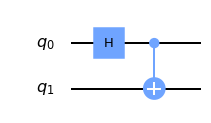

In [2]:
qc = QuantumCircuit(2) #Quantum circuit with 2 qubits
qc.h(0) # Hadamard on the qubit-0
qc.cx(0,1) #CNOT operation with qubit-0 control and qubit-1 objective
qc.draw(output='mpl')

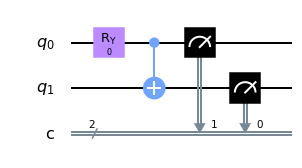

In [3]:
def generateCircuit(theta): #Drawing of the circuit to obtain 
    #an optimal parameter which will lead us to an output 
    #of |01> and |10> with equal probability
    circuit = QuantumCircuit(2,2) 
    circuit.ry(theta,0) 
    circuit.cx(0,1)
    circuit.measure([0,1],[1,0])
    return circuit

generateCircuit(0).draw(output='mpl')

In [4]:
circuit = generateCircuit(np.pi/2)#Simulator to determine if above circuit works

results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1000).result().get_counts()

print(results)

{'00': 489, '11': 511}


In [5]:
def evaluateFunction(theta, number_measurements): #Evaluate the function above
    
    results = execute(generateCircuit(theta), backend=BasicAer.get_backend('qasm_simulator'), 
                      shots=number_measurements).result().get_counts()
    
    c_vector = np.array([0,0,0,0])
    c_vector[0] = results.get("00", 0)
    c_vector[1] = results.get("01", 0)
    c_vector[2] = results.get("10", 0)
    c_vector[3] = results.get("11", 0)
    c_vector = c_vector / np.linalg.norm(c_vector,ord=2)

    objective_vector = np.array([1/np.sqrt(2), 0,0, 1/np.sqrt(2)])
    
    return np.linalg.norm(objective_vector - c_vector, ord=2)

In [6]:
learning_rate = 0.05 # Alpha value used for gradient descent
max_iteration = 1000 # Max number of iterations to avoid infinite looping
precision = 0.1 # Precision, we want to get as close to zero when evaluating F(θ) as possible.
measurements = 1000 # Number of measurements of the circuit
theta = random.random() # Initialize theta as a random value
h_value = 0.01 # h value used in the finite difference method to estimate the derivative of F

function_value = evaluateFunction(theta, measurements) # Calculate the initial estimated value for the initial parameter

print("Initial theta: ", theta)
print("Initial function value: ", function_value)

Initial theta:  0.8260040185197635
Initial function value:  0.5520559148695122


In [7]:
vector_thetas = [theta] #Thetas calculated
vector_function_values = [function_value] #Values of the function obtained

In [8]:
iteration = 0 
vector_iteration = [iteration] #Indexes of iterations

while np.linalg.norm(function_value) > precision and iteration < max_iteration: 
    
    # Calculate the derivative using the finite difference method
    finite_difference = (evaluateFunction(theta + h_value, measurements) - evaluateFunction(theta, measurements)) / h_value
    
    # New value of theta is calculated
    theta = theta - learning_rate * finite_difference
    function_value = evaluateFunction(theta, measurements)
    
    # Save all information related to the execution of this iteration
    vector_thetas.append(theta)
    vector_function_values.append(function_value)
    iteration += 1
    vector_iteration.append(iteration)

In [9]:
print("Optimal theta: ", np.pi/2)
print("Estimation theta:", theta)

Optimal theta:  1.5707963267948966
Estimation theta: 1.6083439041944567


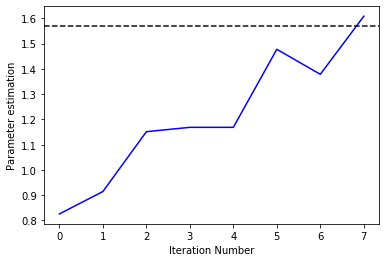

In [10]:
plt.plot(vector_iteration,vector_thetas,color='#0000ff') #Iteration process of parameter estimation
plt.axhline(y=np.pi/2,color='#0F0F0F',ls='--')
plt.xlabel('Iteration Number')
plt.ylabel('Parameter estimation')
plt.show()

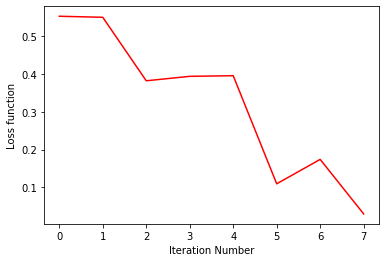

In [11]:
plt.plot(vector_iteration,vector_function_values,color='#ff0000') #Iteration of loss function
plt.xlabel('Iteration Number')
plt.ylabel('Loss function')
plt.show()

In [13]:
def simpleCircuitGenerator(parameters):
    theta = parameters[0]
    circuit = QuantumCircuit(2,2) 
    circuit.ry(theta,0) 
    circuit.cx(0,1)
    circuit.measure([0,1],[1,0])
    return circuit

In [14]:
def simpleLossFunction(circuitGenerator, parameters, measurements):
    results = execute(circuitGenerator(parameters), backend=BasicAer.get_backend('qasm_simulator'), 
                      shots=measurements).result().get_counts()
    c_vector = np.array([0,0,0,0])
    c_vector[0] = results.get("00", 0)
    c_vector[1] = results.get("01", 0)
    c_vector[2] = results.get("10", 0)
    c_vector[3] = results.get("11", 0)
    c_vector = c_vector / np.linalg.norm(c_vector,ord=2)
    objective_vector = np.array([1/np.sqrt(2), 0,0, 1/np.sqrt(2)])
    return np.linalg.norm(objective_vector - c_vector, ord=2)

In [15]:
class VectorEstimation:
    
    def __init__(self, circuitGenerator, initial_parameters, lossFunction, precision = 0.1, 
                 learning_rate = 0.05, max_iteration = 1000, measurements = 1000, h_value = 0.01):
        
        self.circuitGenerator = circuitGenerator
        self.lossFunction = lossFunction
        self.initial_parameters = initial_parameters
        self.precision = precision
        self.learning_rate = learning_rate
        self.max_iteration = max_iteration
        self.measurements = measurements
        self.h_value = h_value
        self.optimal_parameters = None
        self.vector_parameters = []
        self.vector_loss_values = []
        self.vector_iteration = []
        self.iteration = 0 
        
    def estimate(self):
        
        loss_value = self.lossFunction(self.circuitGenerator, self.initial_parameters, self.measurements)
        current_parameters = self.initial_parameters
        
        self.vector_parameters.append(current_parameters)
        self.vector_iteration.append(self.iteration)
        self.vector_loss_values.append(loss_value)
        
        while np.linalg.norm(loss_value) > self.precision and self.iteration < self.max_iteration:
            new_parameters = current_parameters.copy()
            for index,parameter in enumerate(current_parameters):
                new_parameters[index] = self.__calculateFiniteDifference(index, current_parameters)
                
            for index,derivative in enumerate(new_parameters):
                current_parameters[index] = current_parameters[index] - self.learning_rate * derivative
            
            loss_value = self.lossFunction(self.circuitGenerator, current_parameters, self.measurements)
            
            self.iteration += 1
            self.vector_parameters.append(current_parameters.copy())
            self.vector_iteration.append(self.iteration)
            self.vector_loss_values.append(loss_value)
        
        self.optimal_parameters = current_parameters
        return self.optimal_parameters, loss_value
    
    def __calculateFiniteDifference(self, index, current_parameters):
        parameters = current_parameters.copy()
        parameters[index] += self.h_value
        finite_difference = (self.lossFunction(self.circuitGenerator, parameters, self.measurements) 
                             - self.lossFunction(self.circuitGenerator, current_parameters, self.measurements)) / h_value
        return finite_difference
    
    def getVectorParameters(self):
        return self.vector_parameters
    
    def getVectorLossValues(self):
        return self.vector_loss_values
    
    def getVectorIterationValues(self):
        return self.vector_iteration
    
    def getOptimalParameters(self):
        return self.optimal_parameters

In [16]:
task2solution = VectorEstimation(circuitGenerator = simpleCircuitGenerator, lossFunction = simpleLossFunction, 
                                 initial_parameters = [random.random()], measurements = 1000)

In [17]:
task2solution.estimate()

([1.4573314743174308], 0.08377874349888277)

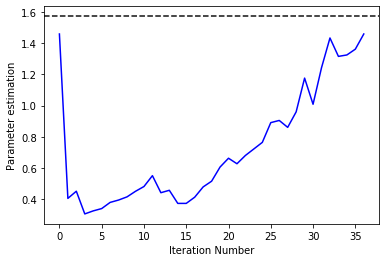

In [18]:
plt.plot(task2solution.getVectorIterationValues(),task2solution.getVectorParameters(),color='#0000ff')
plt.axhline(y=np.pi/2,color='#0F0F0F',ls='--')
plt.xlabel('Iteration Number')
plt.ylabel('Parameter estimation')
plt.show()

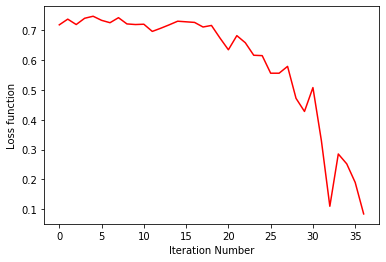

In [19]:
plt.plot(task2solution.getVectorIterationValues(),task2solution.getVectorLossValues(),color='#ff0000')
plt.xlabel('Iteration Number')
plt.ylabel('Loss function')
plt.show()

In [20]:
vector_measurements = [1, 10, 100, 1000]
taskList = []

for measurements in vector_measurements:
    start = time.time()
    print("Start measurement [", measurements, "]")
    task2solution = VectorEstimation(circuitGenerator = simpleCircuitGenerator, lossFunction = simpleLossFunction, 
                                 initial_parameters = [random.random()], measurements = measurements)
    task2solution.estimate()
    end = time.time()
    print(" \t -> Finished. Total time: ", end-start)
    taskList.append(task2solution)

Start measurement [ 1 ]
 	 -> Finished. Total time:  9.806621789932251
Start measurement [ 10 ]
 	 -> Finished. Total time:  3.4042768478393555
Start measurement [ 100 ]
 	 -> Finished. Total time:  3.569005250930786
Start measurement [ 1000 ]
 	 -> Finished. Total time:  4.191661834716797


In [21]:
print("Measurement [1]: ", taskList[0].getOptimalParameters())#Optimal parameters for each set of measurements
print("Measurement [10]: ", taskList[1].getOptimalParameters())
print("Measurement [100]: ", taskList[2].getOptimalParameters())
print("Measurement [1000]: ", taskList[3].getOptimalParameters())
print("Possible optimal: ", np.pi/2)

Measurement [1]:  [0.30971243505552126]
Measurement [10]:  [-4.846410383078787]
Measurement [100]:  [-1.7798810868059332]
Measurement [1000]:  [1.5676597151497151]
Possible optimal:  1.5707963267948966
